In [1]:
!pip install deepdow

In [2]:
# Load libraries
from deepdow.benchmarks import Benchmark, OneOverN, Random
from deepdow.callbacks import EarlyStoppingCallback, ModelCheckpointCallback
from deepdow.data import InRAMDataset, RigidDataLoader, prepare_standard_scaler, Scale
from deepdow.data.synthetic import sin_single
from deepdow.experiments import Run
from deepdow.layers import (AttentionCollapse, AverageCollapse, CovarianceMatrix, Conv, NumericalMarkowitz, RNN, SoftmaxAllocator, WeightNorm)
from deepdow.losses import MeanReturns, SharpeRatio, MaximumDrawdown, CumulativeReturn, Alpha
from deepdow.visualize import generate_metrics_table, generate_weights_table, plot_metrics, plot_weight_heatmap
from deepdow.utils import prices_to_returns, raw_to_Xy
from deepdow.nn import BachelierNet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import datetime
import math
from numpy.random import choice
import random
import sys

from collections import deque
import matplotlib.pylab as plt

import yfinance as yf

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
# All model architectures.
class GreatNet(torch.nn.Module):
    def __init__(self, n_input, node_list, n_output, p=0.5):
        super().__init__()

        self.dropout_layer = torch.nn.Dropout(p=p)
        self.input_layer = torch.nn.Linear(n_input, node_list[0], bias=True)
        self.hidden_layers = nn.ModuleList()
        if node_list:
          for i in range(len(node_list)-1):
            self.hidden_layers.append(torch.nn.Linear(node_list[i], node_list[i+1], bias=True))

        self.output_layer = torch.nn.Linear(node_list[-1], n_output, bias=True)

    def forward(self, x):
        # n_samples, _ = x.shape
        # x = x.view(n_samples, -1)  # flatten features
        x = self.dropout_layer(x)
        x = F.relu(self.input_layer(x))
        for layer in self.hidden_layers:
          x = F.relu(layer(x))
        x = self.output_layer(x)

        return x

class AssetLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout):
        super(AssetLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout = dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)#.to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)#.to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = F.relu(self.fc(out[:, -1, :]))
        return out

class LSTMNet(torch.nn.Module, Benchmark):
  def __init__(self, n_assets, n_channels, hidden_size, output_size, num_layers = 1, p_dropout=0.5, node_list = []):
        super().__init__()
        self.n_assets = n_assets
        self.n_channels = n_channels
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size

        self.lstms = nn.ModuleList()
        for _ in range(n_assets):
          self.lstms.append(AssetLSTM(n_channels, hidden_size, num_layers, output_size, dropout = p_dropout))
        if node_list:
          self.fc = GreatNet(output_size*n_assets, node_list, n_assets, p=0.5)
        else:
          self.fc = nn.Linear(output_size * n_assets, n_assets)
        self.allocate_layer = SoftmaxAllocator(temperature=None)
        self.temperature = torch.nn.Parameter(torch.ones(1), requires_grad=True)
  def forward(self, x):
        outputs = []
        for i in range(self.n_assets):
            # print(x.shape)
            # print(x[:, :, :,i].shape)
            # print(x[:, :, :,i].permute(0,2,1).shape)
            # print(self.lstms[i](x[:, :, :,i].permute(0,2,1)).shape)
            out = self.lstms[i](x[:, :, :,i].permute(0,2,1))
            outputs.append(out)
        output_concat = torch.cat(outputs, dim=1)
        # print(output_concat.shape)
        out = self.fc(output_concat)
        # print(out.shape)
        weights = self.allocate_layer(out, self.temperature)
        return weights

class SingleLSTMNet(torch.nn.Module, Benchmark):
  def __init__(self, n_assets, n_channels, hidden_size, output_size, num_layers = 1, p_dropout=0.5, node_list = []):
        super().__init__()
        self.n_assets = n_assets
        self.n_channels = n_channels
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size

        self.lstm = AssetLSTM(n_channels, hidden_size, num_layers, output_size, dropout = p_dropout)

        if node_list:
          self.fc = GreatNet(output_size*n_assets, node_list, n_assets, p=0.5)
        else:
          self.fc = nn.Linear(output_size * n_assets, n_assets)
        self.allocate_layer = SoftmaxAllocator(temperature=None)
        self.temperature = torch.nn.Parameter(torch.ones(1), requires_grad=True)
  def forward(self, x):
        outputs = []
        for i in range(self.n_assets):
            out = self.lstm(x[:, :, :,i].permute(0,2,1))
            outputs.append(out)
        output_concat = torch.cat(outputs, dim=1)
        # print(output_concat.shape)
        # print(self.output_size*self.n_assets)
        out = self.fc(output_concat)
        # print(out.shape)
        weights = self.allocate_layer(out, self.temperature)
        return weights

In [4]:
# Specify the stocks and download the stock data throughout the specified time period. Check if contains any nan-values. Replace non-positive values.
stocks = ['GOOG', 'MSFT', 'TSLA', 'C', 'COST', 'WMT', 'AMZN', 'NVDA', 'AMD', 'META',
          'JPM', 'XOM', 'MRO', 'JNJ', 'PG', 'PFE', 'LLY', 'UNH', 'T', 'MCD']

raw_df = yf.download(stocks, start="2012-05-18", end="2023-12-31", group_by='ticker')
if not np.all(raw_df > 0):
  raw_df[raw_df <= 0] = 1
raw_df.isnull().values.any()

[*********************100%%**********************]  20 of 20 completed


False

In [5]:
# Model list and parameters to produce the final plots. If in colab, upload 'Models' folder from the repo.
model_dict = {'SingleLSTMNet': {'modelPath':'/content/Models/18_SingleLSTMNet.pth',
                                'lookback':50,
                                'horizon':20,
                                 'indicators':['Close']},
              'BachelierNet': {'modelPath':'/content/Models/19.2_BachelierNet.pth',
                               'lookback':40,
                               'horizon':20,
                                'indicators':['Close']},
              'LSTMNet1':{'modelPath':'/content/Models/6_LSTMNet1.pth',
                               'lookback':60,
                               'horizon':45,
                                'indicators':['Close']},
              'LSTMNet2':{'modelPath':'/content/Models/2_LSTMNet2.pth',
                               'lookback':60,
                               'horizon':20,
                                'indicators':['Close']},
              }

In [6]:
# The code is slightly changed to align the final plots so all the portfolios start from the same day.
n_timesteps = len(raw_df)
N = 2035 + 59 # timestamps[2035-lookback] corresponds to middle of covid 03/06/2020 - middle of covid

for model,params in model_dict.items():
  lookback = params['lookback']
  horizon = params['horizon']
  n_samples =  n_timesteps - lookback - horizon + 1
  X, timestamps, y, asset_names, indicators = raw_to_Xy(raw_df,
                                                      lookback=lookback,
                                                      gap=0,
                                                      freq="B",
                                                      horizon=params['horizon'],
                                                      included_assets=stocks,
                                                      included_indicators = params['indicators'],
                                                      use_log=False)

  params['split_ix'] = N - lookback
  params['test_split_ix'] = N + (n_samples-N)//2
  params['n_samples'] = n_samples
  # params['indices_train'] = list(range(split_ix))
  # params['indices_val'] = list(range(split_ix + lookback, test_split_ix - lookback))
  # params['indices_test'] = list(range(test_split_ix, n_samples))
  means, stds = prepare_standard_scaler(X, indices=list(range(params['split_ix'])))
  params['dataset'] = InRAMDataset(X, y, timestamps=timestamps, asset_names=asset_names, transform=Scale(means, stds))

In [7]:
# Utility functions to calculate portfolio returns using the weights given by the model.
def duplicate_rows(tensor, n, split_index):
    # Get the dimensions of the input tensor
    rows, cols = tensor.shape

    # Create an empty tensor to store the duplicated rows
    duplicated_tensor = torch.empty(rows * n, cols, dtype=tensor.dtype)

    # Duplicate each row n times
    for i in range(rows):
        duplicated_tensor[i*n:(i+1)*n, :] = tensor[i, :].unsqueeze(0).repeat(n, 1)
    return duplicated_tensor[:split_index,:]


def getPortfolioReturn(network, params, is_val = True):
  dataset = params['dataset']
  X = torch.empty(0)
  Y = torch.empty(0)
  timestamps = []
  if is_val:
    indices = list(range(params['split_ix'], params['test_split_ix']))
  else:
    indices = list(range(params['test_split_ix'], params['n_samples']))

  for i in range(indices[0], indices[-1]+1):
    X_sample, Y_sample, timestamps_sample, _ = dataset.__getitem__(i)
    X = torch.cat((X,X_sample.unsqueeze(0)), dim = 0)
    Y = torch.cat((Y,Y_sample.unsqueeze(0)), dim = 0)
    timestamps.append(timestamps_sample)
  X = X.float()

  crets = Y[:,0,0,:] + 1
  crets = crets.unsqueeze(1)

  with torch.no_grad():
    weights = duplicate_rows(network(X),params['horizon'],len(indices))
  weights = weights.unsqueeze(2)

  portfolio_return = torch.bmm(crets.double(), weights.double()).squeeze(1).squeeze(1)
  portfolio_return = torch.cumprod(portfolio_return, dim=0)
  if is_val:
    params['val_timestamps'] = timestamps
    params['val_return'] = portfolio_return
  else:
    params['test_timestamps'] = timestamps
    params['test_return'] = portfolio_return


In [8]:
# Utility function to calculate equal hold and one-asset portfolio returns.
def getBenchmarkReturns(benchmark_stocks, is_val = True):
  X, timestamps, y, asset_names, indicators = raw_to_Xy(raw_df,
                                                      lookback=1,
                                                      gap=0,
                                                      freq="B",
                                                      horizon=1,
                                                      included_assets=stocks,
                                                      included_indicators = ['Close'],
                                                      use_log=False)

  n_timesteps = len(raw_df)
  n_samples =  n_timesteps - 1
  n_assets = len(asset_names)

  N = 2035 + 59 # timestamps[2035-lookback] corresponds to middle of covid 03/06/2020 - middle of covid
  split_ix = N - 1
  test_split_ix = N + (n_samples-N)//2
  indices_val = list(range(split_ix + 1, test_split_ix + 10))
  indices_test = list(range(test_split_ix, n_samples-25))
  if is_val:
    indices = indices_val
  else:
    indices = indices_test

  rets = torch.tensor(y[indices,0,0,:])+1
  rets = rets.unsqueeze(1)

  n_eq_weights = torch.ones([len(indices),n_assets])/n_assets
  n_eq_weights = n_eq_weights.unsqueeze(2)

  n_eq_return = torch.bmm(rets.double(), n_eq_weights.double()).squeeze(1).squeeze(1)
  n_eq_return = torch.cumprod(n_eq_return, dim=0)

  if benchmark_stocks:
    stock_returns = {}
    for stock in benchmark_stocks:
      index = asset_names.index(stock)
      stock_weights = torch.zeros([len(indices),n_assets])
      stock_weights[:,index] = 1
      stock_weights = stock_weights.unsqueeze(2)
      stock_return = torch.bmm(rets.double(), stock_weights.double()).squeeze(1).squeeze(1)
      stock_return = torch.cumprod(stock_return, dim=0)
      stock_returns[stock] = stock_return
    return n_eq_return, timestamps[indices], stock_returns
  else:
    return n_eq_return, timestamps[indices]


In [10]:
# Calculate the portfolio return for each model and add them to their parameter dictionary.
for model,params in model_dict.items():
  currentModel = torch.load(params['modelPath'])
  currentModel = currentModel.eval()
  getPortfolioReturn(currentModel, params, is_val = True)
  getPortfolioReturn(currentModel, params, is_val = False)

In [11]:
# Calculate returns for the benchmark portfolios.
_eq_return, val_timestamps, stock_returns = getBenchmarkReturns(['TSLA', 'NVDA'], is_val = True)

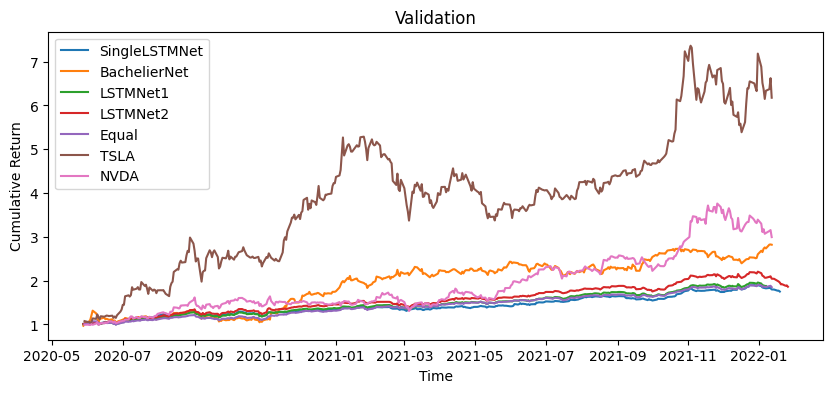

In [12]:
# Plot the result for the validation period.

plt.figure(figsize=(10,4))

for model,params in model_dict.items():
  val_timestamps = params['val_timestamps']
  val_return = params['val_return']
  plt.plot(val_timestamps,val_return, label = model)

n_eq_return, val_timestamps, stock_returns = getBenchmarkReturns(['TSLA', 'NVDA'], is_val = True)
# n_eq_return, val_timestamps, stock_returns = getBenchmarkReturns(['NVDA'], is_val = True)
plt.plot(val_timestamps,n_eq_return, label = 'Equal')

for stock, stock_return in stock_returns.items():
  plt.plot(val_timestamps,stock_return, label = stock)
plt.legend()
plt.title('Validation')
plt.xlabel('Time')
plt.ylabel('Cumulative Return')

plt.show()

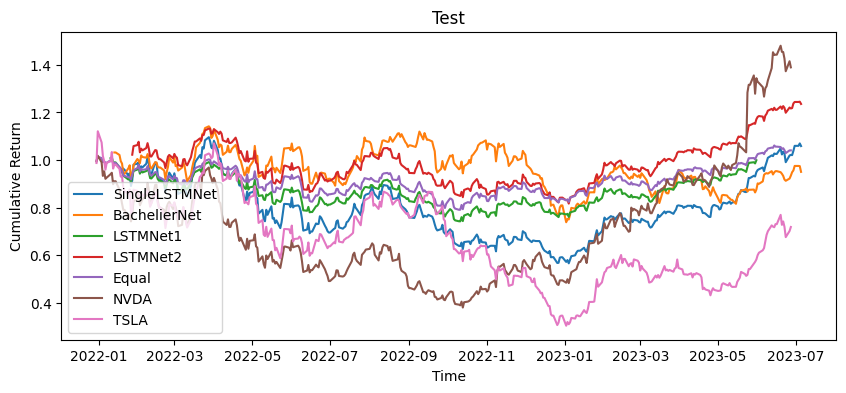

In [13]:
# Plot the result for the test period.
plt.figure(figsize=(10,4))

for model,params in model_dict.items():
  test_timestamps = params['test_timestamps']
  test_return = params['test_return']
  plt.plot(test_timestamps,test_return, label = model)

n_eq_return, test_timestamps, stock_returns = getBenchmarkReturns(['NVDA','TSLA'], is_val = False)
plt.plot(test_timestamps,n_eq_return, label = 'Equal')

for stock, stock_return in stock_returns.items():
  plt.plot(test_timestamps,stock_return, label = stock)
plt.legend()
plt.title('Test')
plt.xlabel('Time')
plt.ylabel('Cumulative Return')

plt.show()